# M6 Exercise - Find a Dataset: Davis Zakary
I have decided to use a Kaggle dataset pertaining to credit card fraud detection.
The [dataset](https://www.kaggle.com/datasets/kelvinobiri/credit-card-transactions/data)
contains one CSV file that has ~200k observations.

| Column         | Description                                  |
|----------------|----------------------------------------------|
| step           | Time step of transaction                     |
| type           | Type of transaction (transfer, cashout)      |
| amount         | Amount involved                              |
| nameOrig       | ID of sender account                         |
| oldbalanceOrg  | Sender's balance before transaction          |
| newbalanceOrig | Sender's balance after transaction           |
| nameDest       | ID of receiver account                       |
| oldbalanceDest | Receiver's balance before the transaction    |
| newbalanceDest | Receiver's balance after the transaction     |
| isFraud        | 1 if fraud, 0 otherwise                      |
| isPayment      | Indicates if transaction is a payment        |
| isMovement     | Indicates if transaction is a balance change |

I decided to use this dataset because it has a large number of rows but is small enough to still fit in memory.
This just makes everything easier when doing analysis.

I also wanted to explore a situation with severe class imbalance.
The number of confirmed fraud transactions are very low, which will likely require some kind of resampling technique.
It has been a while since I have learned about / used resampling techniques, so I would like to reinforce that skill.


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('Data/credit_card_fraud.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            199999 non-null  int64  
 1   type            199999 non-null  object 
 2   amount          199999 non-null  float64
 3   nameOrig        199999 non-null  object 
 4   oldbalanceOrg   199999 non-null  float64
 5   newbalanceOrig  199999 non-null  float64
 6   nameDest        199999 non-null  object 
 7   oldbalanceDest  199999 non-null  float64
 8   newbalanceDest  199999 non-null  float64
 9   isFraud         199999 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 15.3+ MB
None
   step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     8  CASH_OUT  158007.12   C424875646           0.00            0.00   
1   236  CASH_OUT  457948.30  C1342616552           0.00            0.00   
2    37   CASH_IN  153602.99   C900876541

### Checking Unique Senders and Receivers

In [9]:
names_o = df['nameOrig'].unique()
names_d = df['nameDest'].unique()
names = np.unique(np.concat((names_o, names_d)))
print(len(names_o), len(names_d), len(names))

199990 174523 374503


By counting the number of unique "names" we can see if any accounts appear multiple times.
Here is what we can deduce from the code block above:
* Nine observations have non-unique sender names
* 25,476 observations have non-unique receiver names
* The unique sender and receiver name list only has 10 overlapping values

It seems that the transactions in this dataset have been simplified to represent the net effect of multiple transactions.
For example, in a raw dataset it might be common to encounter a string of related transactions such as:
1. A -> B
2. B -> C
3. C -> D

I speculate that if the data were structured this way at one point, the transactions have since been condensed before being placed into the CSV.
Otherwise, we could expect to see many more overlapping values between the sender and receiver lists.
In our example above, both B and C would appear on the sender and receiver list.

**TLDR:** We should treat the rows as un-linked transactions. No feature engineering needs to be done to help the model capture the idea of a transaction sequence.

### Checking Repeat Receivers

In [19]:
receivers = df.groupby(by='nameDest').aggregate(
    {'step': 'count', 'isFraud': 'sum'}
)
receivers.columns = ['Transactions', 'Fraud']
receivers.sort_values(by='Transactions', ascending=False, inplace=True)
mask = (receivers['Transactions'] > 1) & (receivers['Fraud'] > 0)
print(receivers[mask])

             Transactions  Fraud
nameDest                        
C311901651              5      1
C347056727              4      1
C677754789              4      1
C644345897              4      1
C1570256460             4      1
C177739457              3      1
C1803198527             3      1
C43869769               3      1
C495237092              3      1
C514736179              3      1
C641860418              3      1
C679714329              2      1
C1068088118             2      1
C627570303              2      1
C1089455271             2      1
C614104997              2      1
C105806122              2      1
C760531323              2      1
C385133759              2      1
C290920701              2      1
C2002380893             2      1
C1992468113             2      1
C1947737398             2      1
C858620596              2      1
C125311108              2      1
C1812639726             2      1
C1808278362             2      1
C1779832819             2      1
C916183053

In [24]:
print(mask.sum())
print(df['isFraud'].sum())
print(mask.sum() / (receivers['Fraud'] > 0).sum())

42
282
0.14893617021276595


It looks like there are a few repeat offenders. 42 accounts are the receiver of fraudulent transactions more than once.
Every one of these 42 accounts only commited fraud once, not multiple times.
We do not have a strong case to say that committing fraud in the past makes you more likely to do it again.
Furthermore, the 42 instances of fraud that were committed by accounts appearning more than once as receivers comprise ~15% of all fraud.

**TLDR:** We don't need to consider the possibility of repeat offenders. We can ignore both the sender and receiver account names when building the model.

### Variable Distributions

In [25]:
print(df['isFraud'].value_counts())

isFraud
0    199717
1       282
Name: count, dtype: int64


The class imbalance in this dataset is insane, as expected.
For every fraudulent transaction, there are millions of others that are legitimate.
This dataset reflects that truth, and we will need to use a resampling method such as SMOTE to generate synthetic data.
Even with SMOTE, we will likely need to use stratified sampling when creating the test train splits.

In [38]:
print(df.groupby(by='type').aggregate(
    {'step': 'count', 'isFraud': 'sum'}
))

           step  isFraud
type                    
CASH_IN   43919        0
CASH_OUT  70571      132
DEBIT      1317        0
PAYMENT   67562        0
TRANSFER  16630      150


We have absolutely zero instances of fraud for 3/5 transaction types.
This may just be an issue with the dataset, or it could actually be a real connection.
Maybe fraud cannot occur for debits, payments, or cash_in?
If we don't prevent it, the model will very likely pick up on this connection and it will be baked into our classification capabilities.

In the future if for some reason we suddenly receive a debit that is fraudulent, the model might autolabel it as non-fraud due to the distribution of our training data.

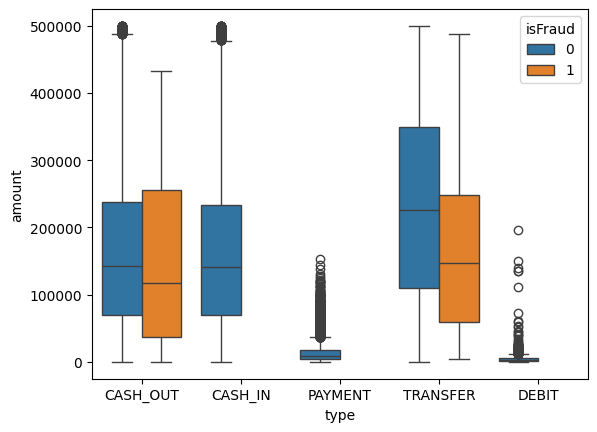

In [37]:
sns.boxplot(df[df['amount'] <= 500_000], x='type', y='amount', hue='isFraud')
plt.show()